In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.signal import butter, filtfilt, detrend
import nbimporter
from align_radar_psg import PSGDataProcessor

plt.rcParams['figure.figsize']=(18, 3)


Bad key text.latex.unicode in file /Users/w.z/opt/anaconda3/envs/fall/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.8.0/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key text.latex.preview in file /Users/w.z/opt/anaconda3/envs/fall/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.8.0/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/w.z/opt/anaconda3/envs/fall/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 157 ('mathtext.

## 1. Camera data processing

### Load data

In [5]:
# Load the CSV file
file_path = '/Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/Camera/camera20240620220949415042.csv'
df = pd.read_csv(file_path)

# Convert timestamp to a proper datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H%M%S%f')

# Display the first few rows of the dataframe
print(df.head())


                   timestamp    mean_r    mean_g    mean_b
0 2024-06-20 22:09:49.626041  2.646389  1.731215  2.085461
1 2024-06-20 22:09:49.632041  2.354803  2.490679  0.455645
2 2024-06-20 22:09:49.640044  1.585553  2.554162  1.299123
3 2024-06-20 22:09:49.647041  1.885192  2.312193  1.587810
4 2024-06-20 22:09:49.655041  1.014810  2.472130  2.951984


In [ ]:
# # Function to visualize the RGB data
# def plot_rgb_frame(ax, data, frame_number):
#     # Ensure frame number is within the correct range
#     if frame_number < 0 or frame_number >= len(data):
#         raise ValueError("Frame number out of range.")
    
#     # Extract the RGB values for the given frame
#     frame = data.iloc[frame_number]
#     r = frame['mean_r']
#     g = frame['mean_g']
#     b = frame['mean_b']
    
#     # Create an image filled with the RGB values
#     img = np.zeros((100, 100, 3), dtype=np.uint8)
#     img[..., 0] = r
#     img[..., 1] = g
#     img[..., 2] = b
    
#     # Display the image on the provided axes
#     ax.imshow(img)
#     ax.set_title(f"Frame {frame_number}")
#     ax.axis('off')



# # Function to plot a series of frames in a grid
# def plot_series_in_grid(data, start_frame, num_frames, grid_size):
#     fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
#     axes = axes.flatten()
    
#     for i in range(num_frames):
#         if i < len(axes):
#             plot_rgb_frame(axes[i], data, start_frame + i)
    
#     # Hide any remaining axes if there are fewer frames than grid slots
#     for ax in axes[num_frames:]:
#         ax.axis('off')
    
#     plt.tight_layout()
#     plt.show()

# # Example usage: plot 25 frames in a 5x5 grid starting from the 0th frame
# plot_series_in_grid(df, 0, 25, 5)

In [6]:
# Assuming 'frame' is a DataFrame containing the mean values of r, g, and b for multiple images or frames
# Calculate the minimum and maximum values for r, g, and b

min_r = df['mean_r'].min()
max_r = df['mean_r'].max()

min_g = df['mean_g'].min()
max_g = df['mean_g'].max()

min_b = df['mean_b'].min()
max_b = df['mean_b'].max()

print(f"Range of r: {min_r} to {max_r}")
print(f"Range of g: {min_g} to {max_g}")
print(f"Range of b: {min_b} to {max_b}")

Range of r: 0.0333072916666666 to 71.705830078125
Range of g: 0.4370431857638889 to 74.03137586805556
Range of b: 0.1429459635416666 to 78.22825737847222


### Extract subset

In [10]:
# Define start and end datetime objects
start_datetime = datetime.strptime('20240620221948', '%Y%m%d%H%M%S')
end_datetime = datetime.strptime('20240620222049', '%Y%m%d%H%M%S')

# Extract the data subset
df_subset = extract_data_subset(df, start_datetime, end_datetime)

# Display the first few rows of the subset
print(df_subset.head())

                       timestamp    mean_r    mean_g    mean_b
66215 2024-06-20 22:20:48.959220  1.663941  2.039664  3.192534
66216 2024-06-20 22:20:48.975219  1.812069  2.015051  2.916569
66217 2024-06-20 22:20:48.983221  2.113390  1.893594  2.648397
66218 2024-06-20 22:20:48.991222  1.631664  2.026009  3.355837
66219 2024-06-20 22:20:48.998222  1.844246  1.992768  2.923908


### Plot RGB values

In [2]:
def plot_rgb(data, start_datetime, end_datetime):
    """
    Plots the green channel of image data with time labels for start and end datetimes.

    Parameters:
    - data: DataFrame containing the image data with a 'green' column for the green channel.
    - start_datetime: The start datetime of the data as a string.
    - end_datetime: The end datetime of the data as a string.
    """
    # Extract the data subset
    
    data_subset = extract_data_subset(data, start_datetime, end_datetime)
    # Extract the green channel data
    green_channel = data_subset['mean_g']
    
    # Plot the green channel
    plt.figure(figsize=(12, 6))
    plt.plot(green_channel, label='Green Channel', color='g')
    plt.xlabel('Time (h:m:s)')
    plt.ylabel('Intensity')
    plt.title('Green Channel Intensity Over Time')
    plt.legend()
    plt.grid(True)
    # Adjust x-axis labels to show only the start and end
    # plt.xticks([0, len(green_channel) - 1], [start_datetime, end_datetime])
    plt.tight_layout()
    plt.show()


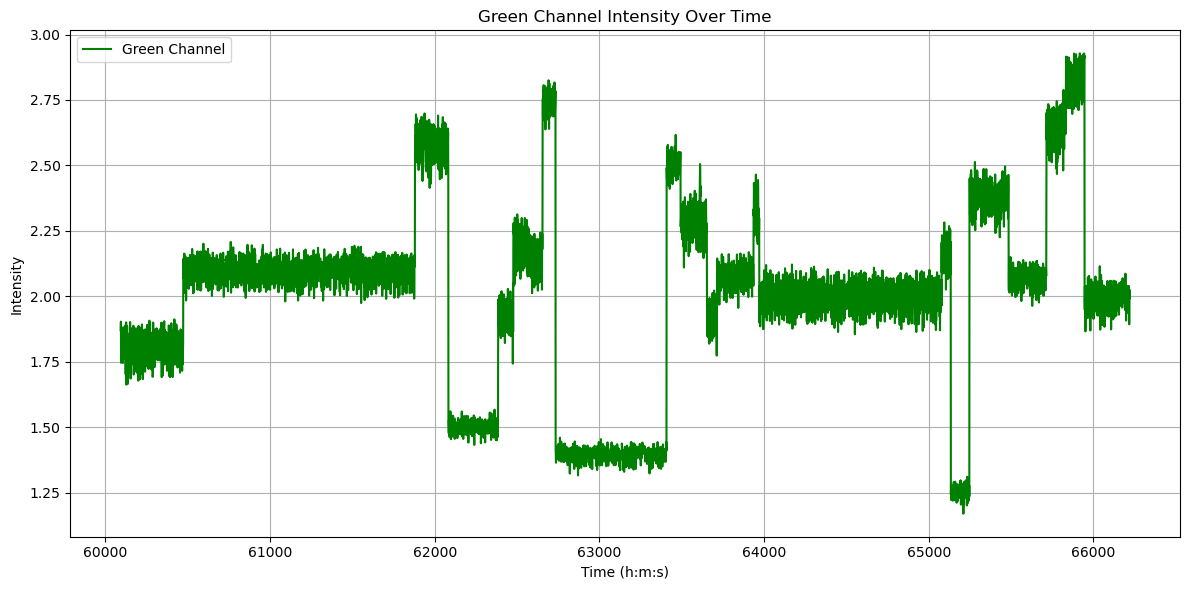

In [23]:
plot_rgb(df, start_datetime, end_datetime)

## 2. Radar signal processing

### Filtering methods (TODO)

In [ ]:
# from scipy.signal import filtfilt, butter

# def separate_breath_and_heartbeat(signal):
#         breath_signal = bandpass_filter(signal, 0.18, 0.35, order=5)
#         heartbeat_signal = bandpass_filter(signal, 1.0, 2.0, order=5)
#         return breath_signal, heartbeat_signal

# def plot_separated_signals(breath_signal, heartbeat_signal):
#     plt.figure(figsize=(10, 8))
    
#     plt.subplot(2, 1, 1)
#     plt.plot(breath_signal)
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude')
#     plt.title('Separated Breath Signal')
    
#     plt.subplot(2, 1, 2)
#     plt.plot(heartbeat_signal)
#     plt.xlabel('Time (s)')
#     plt.ylabel('Amplitude')
#     plt.title('Separated Heartbeat Signal')
    
#     plt.tight_layout()
#     plt.show()
    
# def bandpass_filter(signal, lowcut, highcut, order=5):
#     nyq = 0.5 * 10
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = butter(order, [low, high], btype='band')
#     filtered_signal = filtfilt(b, a, signal)
#     print(low)
#     print(high)
#     print(b)
#     print(a)
#     print(filtered_signal)

#     return filtered_signal

# breath, heart = separate_breath_and_heartbeat(filtered_signal)
# plot_separated_signals(breath, heart)

### Data extraction and processing methods

In [4]:


def extract_data_subset(data, start_datetime, end_datetime):
    """
    Extracts a subset of data from a DataFrame given the start and end datetimes.
    
    Parameters:
    - data: DataFrame containing the data.
    - start_datetime: Start datetime as a datetime object.
    - end_datetime: End datetime as a datetime object.
    
    Returns:
    - A DataFrame containing the subset of data between the specified start and end datetimes.
    """
    # Ensure 'timestamp' column is in datetime format
    data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y%m%d%H%M%S%f')
    
    # Filter the data based on the start and end datetimes
    data_subset = data[(data['timestamp'] >= start_datetime) & (data['timestamp'] <= end_datetime)]

    return data_subset

def process_signal(data, sample_rate):
    """
    Process the signal by performing arctan demodulation, phase unwrapping,
    detrending, and low-pass filtering.

    Parameters:
    - data: DataFrame containing the in-phase (data_i) and quadrature (data_q) components of the signal.
    - sample_rate: The sample rate of the signal.

    Returns:
    - filtered_signal: The processed signal.
    """
    
    # Extract the data columns
    data_i = data['data_i'].astype(float)
    data_q = data['data_q'].astype(float)

    # Perform arctan demodulation
    sig = np.arctan2(data_q, data_i)

    # Perform phase unwrapping
    sig_unwrapped = np.unwrap(np.angle(sig))
    sig_unwrapped = detrend(sig_unwrapped)

    # Design a low-pass filter and apply it
    d1 = butter(4, 5 / (0.5 * sample_rate), btype='low')
    filtered_signal = filtfilt(d1[0], d1[1], sig_unwrapped)

    return filtered_signal

def plot_processed_data(data, sample_rate, start_datetime, end_datetime):
    """
    Plots the processed signal data with time labels for start and end datetimes.

    Parameters:
    - data: DataFrame containing the signal data.
    - sample_rate: The sample rate of the signal.
    - start_datetime: The start datetime of the data as a string.
    - end_datetime: The end datetime of the data as a string.
    """

    # Extract the data subset based on the start and end datetimes
    data_subset = extract_data_subset(data, start_datetime, end_datetime)

    # Process the signal
    filtered_signal = process_signal(data_subset, sample_rate)
        
    # Plot the processed signal
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_signal, label='Unwrapped Phase')
    plt.xlabel('Time (h:m:s)')
    plt.ylabel('Phase (radians)')
    plt.title('Phase Unwrapping of Radar Signal')
    plt.legend()
    plt.grid(True)
    # Adjust x-axis labels to show only the start and end
    plt.xticks([0, len(filtered_signal) - 1], [start_datetime, end_datetime])
    plt.tight_layout()
    plt.show()

### Load data

In [26]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.signal import butter, filtfilt, detrend

# Sample file path
file_path = "/Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/Radar/radar20240620220948433561.csv"

# Load the data from the file
data = pd.read_csv(file_path)
start_time = pd.to_datetime(data['timestamp'].iloc[0], format='%Y%m%d%H%M%S%f').strftime('%H%M%S') # 22:09:48
sample_rate = 1000

### Extract the data subset

In [4]:
# Define start and end datetime objects
start_datetime = datetime.strptime('20240620221948', '%Y%m%d%H%M%S')
end_datetime = datetime.strptime('20240620222049', '%Y%m%d%H%M%S')

# Extract the data subset
data_subset = extract_data_subset(data, start_datetime, end_datetime)

# Display the first few rows of the subset
print(data_subset.head())

                        timestamp  data_i  data_q
600814 2024-06-20 22:19:48.002360  -0.049  -0.011
600815 2024-06-20 22:19:48.002360  -0.032   0.003
600816 2024-06-20 22:19:48.002360  -0.041  -0.013
600817 2024-06-20 22:19:48.004360  -0.046  -0.017
600818 2024-06-20 22:19:48.005361  -0.054  -0.025


### Plot the processed radar data

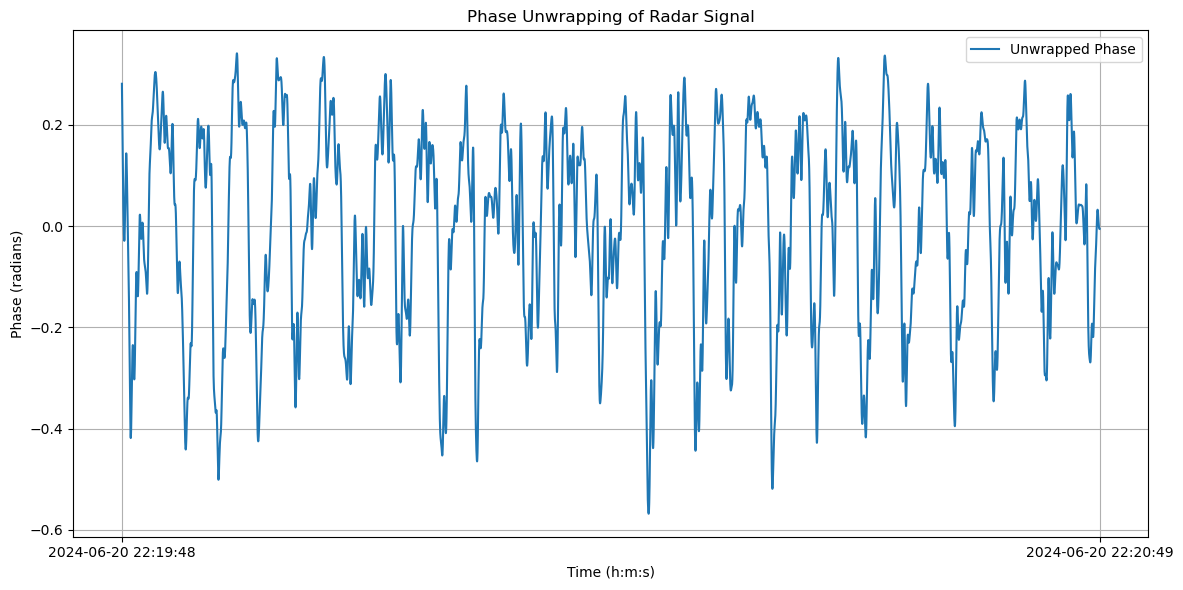

In [25]:
plot_processed_data(data, sample_rate, start_datetime, end_datetime)


### Frequency analysis: FFT plot

In [ ]:
# Assuming sig_unwrapped is a 1D numpy array
# Compute the FFT of the signal
fft_values = np.fft.fft(sig_unwrapped)

# Compute the frequencies corresponding to the FFT values
# N is the number of points in sig_unwrapped, and T is the sampling interval
N = len(sig_unwrapped)
T = 1/sample_rate  # Assuming a sampling rate of 1 Hz, adjust T according to your actual sampling rate
frequencies = np.fft.fftfreq(N, T)

# Compute the magnitude of the FFT values
magnitude = np.abs(fft_values)

# Compute the one-sided frequency range
# Include Nyquist frequency only if N is odd
if N % 2 == 0:
    freq_range = frequencies[:N//2]
    magnitude_range = magnitude[:N//2]
else:
    freq_range = frequencies[:(N+1)//2]
    magnitude_range = magnitude[:(N+1)//2]

# Plot the one-sided frequency map
plt.figure(figsize=(10, 6))
plt.plot(freq_range, magnitude_range)
plt.title('One-sided Frequency Map of sig_unwrapped')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 5)  # Limit the x-axis to 0 to 5 Hz
plt.grid(True)
plt.show()

### Downsampling methods (TODO)

In [4]:
import pandas as pd
import numpy as np
from scipy.signal import resample

def calculate_sampling_rate(timestamps, desired_sampling_rate):
    """
    Calculates the original sampling rate and the downsample factor based on desired sampling rate.

    Parameters:
    - timestamps: Pandas Series of timestamps.
    - desired_sampling_rate: The desired sampling rate after downsampling.

    Returns:
    - A tuple containing the original sampling rate and the downsample factor.
    """
    time_diffs = timestamps.diff().dropna()
    avg_time_diff = time_diffs.mean().total_seconds()
    original_sampling_rate = 1 / avg_time_diff
    downsample_factor = int(original_sampling_rate / desired_sampling_rate)
    
    return original_sampling_rate, downsample_factor

def downsample_signal(data, sampling_type='average', desired_sampling_rate=128):
    """
    Downsamples the signal data to a desired sampling rate using either the Fourier or average method.
    
    Parameters:
    - data: DataFrame containing the signal data with 'timestamp', 'data_i', and 'data_q' columns.
    - sampling_type: The method of downsampling ('fourier' or 'average'). Default is 'average'.
    - desired_sampling_rate: The desired sampling rate after downsampling. Default is 128 Hz.
    
    Returns:
    - A DataFrame containing downsampled 'timestamp', 'data_i', and 'data_q' columns.
    """
    # Make a copy of the original data
    data_copy = data.copy()
    
    # Convert the timestamps to datetime objects and calculate the original sampling rate
    timestamps = pd.to_datetime(data_copy['timestamp'], format='%Y%m%d%H%M%S%f')
    original_sampling_rate, downsample_factor = calculate_sampling_rate(timestamps, desired_sampling_rate)

    
    # Extract the data columns
    data_i = data_copy['data_i'].astype(float)
    data_q = data_copy['data_q'].astype(float)
    
    if sampling_type == 'fourier':
        # Fourier method down-sampling
        num_samples = len(data_i) // downsample_factor
        data_i_downsampled = resample(data_i, num_samples)
        data_q_downsampled = resample(data_q, num_samples)
        
        # Downsample timestamps by taking every nth timestamp
        timestamps_downsampled = timestamps[::downsample_factor].reset_index(drop=True)
    else:
        # Average method down-sampling
        def average_downsample(signal, factor):
            n = len(signal) // factor
            return np.mean(signal.values[:n*factor].reshape(-1, factor), axis=1)
        
        data_i_downsampled = average_downsample(data_i, downsample_factor)
        data_q_downsampled = average_downsample(data_q, downsample_factor)
        
        timestamps_downsampled = average_downsample(timestamps.astype(np.int64), downsample_factor)
        timestamps_downsampled = pd.to_datetime(timestamps_downsampled)
        
    # Ensure the lengths of downsampled arrays match
    min_length = min(len(timestamps_downsampled), len(data_i_downsampled), len(data_q_downsampled))
    timestamps_downsampled = timestamps_downsampled[:min_length]
    data_i_downsampled = data_i_downsampled[:min_length]
    data_q_downsampled = data_q_downsampled[:min_length]

    # Create a DataFrame with downsampled data
    downsampled_data = pd.DataFrame({
        'timestamp': timestamps_downsampled,
        'data_i': data_i_downsampled,
        'data_q': data_q_downsampled
    })
    
    return downsampled_data

# Example usage
# data = pd.read_csv('path_to_your_data.csv')
# downsampled_data = downsample_signal(data, sampling_type='average', desired_sampling_rate=128)


In [68]:
downsampled_data = downsample_signal(data_subset, sampling_type='average', desired_sampling_rate=128)
downsampled_data.head()


,timestamp,data_i,data_q
0,2024-06-20 22:19:48.004217344,-0.046286,-0.015000
1,2024-06-20 22:19:48.011075840,-0.045714,-0.013571
2,2024-06-20 22:19:48.017934080,-0.047143,-0.017143
3,2024-06-20 22:19:48.025361664,-0.053000,-0.022714
4,2024-06-20 22:19:48.032218880,-0.047857,-0.017714


In [69]:
timestamp_diffs = downsampled_data['timestamp'].diff().dropna()
timestamp_diffs.describe()

count                         8731
mean     0 days 00:00:00.006985470
std      0 days 00:00:00.000331367
min      0 days 00:00:00.003715328
25%      0 days 00:00:00.006714624
50%      0 days 00:00:00.006859264
75%      0 days 00:00:00.007143424
max      0 days 00:00:00.009713920
Name: timestamp, dtype: object

In [70]:
downsampled_data = downsample_signal(data_subset, sampling_type='fourier', desired_sampling_rate=128)
downsampled_data.head()


,timestamp,data_i,data_q
0,2024-06-20 22:19:48.002360,-0.046814,-0.013302
1,2024-06-20 22:19:48.008361,-0.044445,-0.013762
2,2024-06-20 22:19:48.014361,-0.047156,-0.016309
3,2024-06-20 22:19:48.022364,-0.054211,-0.024736
4,2024-06-20 22:19:48.028361,-0.047424,-0.016106


In [71]:
timestamp_diffs = downsampled_data['timestamp'].diff().dropna()
timestamp_diffs.describe()

count                         8731
mean     0 days 00:00:00.006985438
std      0 days 00:00:00.001028855
min         0 days 00:00:00.002004
25%         0 days 00:00:00.006000
50%         0 days 00:00:00.007000
75%         0 days 00:00:00.008000
max         0 days 00:00:00.011002
Name: timestamp, dtype: object

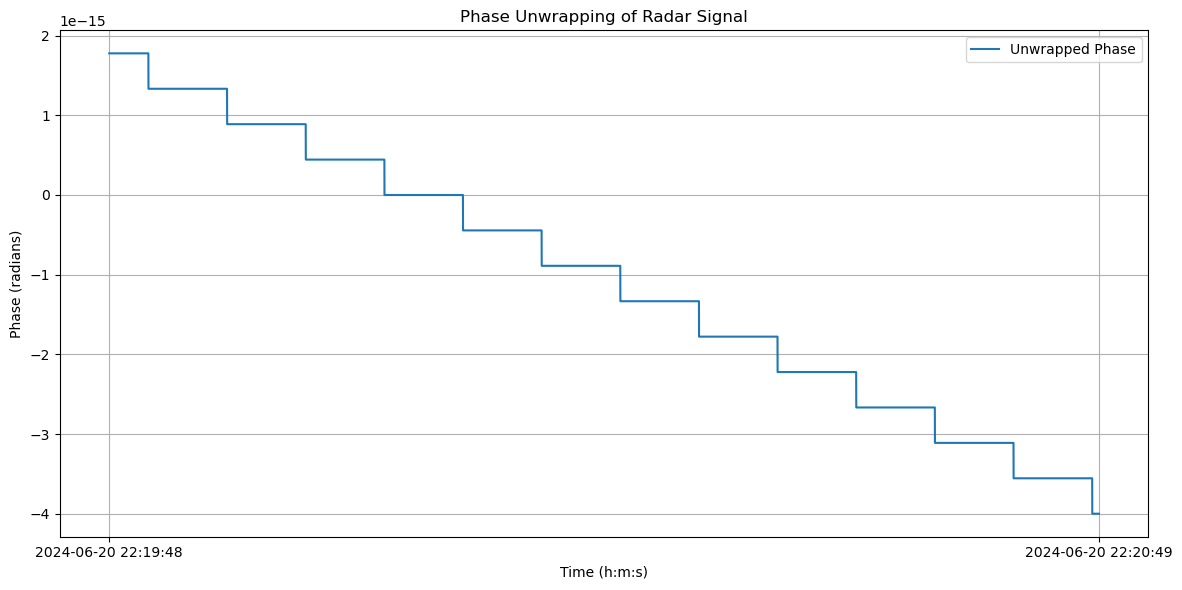

In [78]:
desired_sampling_rate=128

# Process the signal
filtered_signal = process_signal(downsampled_data, desired_sampling_rate)
    
# Plot the processed signal
plt.figure(figsize=(12, 6))
plt.plot(filtered_signal, label='Unwrapped Phase')
plt.xlabel('Time (h:m:s)')
plt.ylabel('Phase (radians)')
plt.title('Phase Unwrapping of Radar Signal')
plt.legend()
plt.grid(True)
# Adjust x-axis labels to show only the start and end
plt.xticks([0, len(filtered_signal) - 1], [start_datetime, end_datetime])
plt.tight_layout()
plt.show()

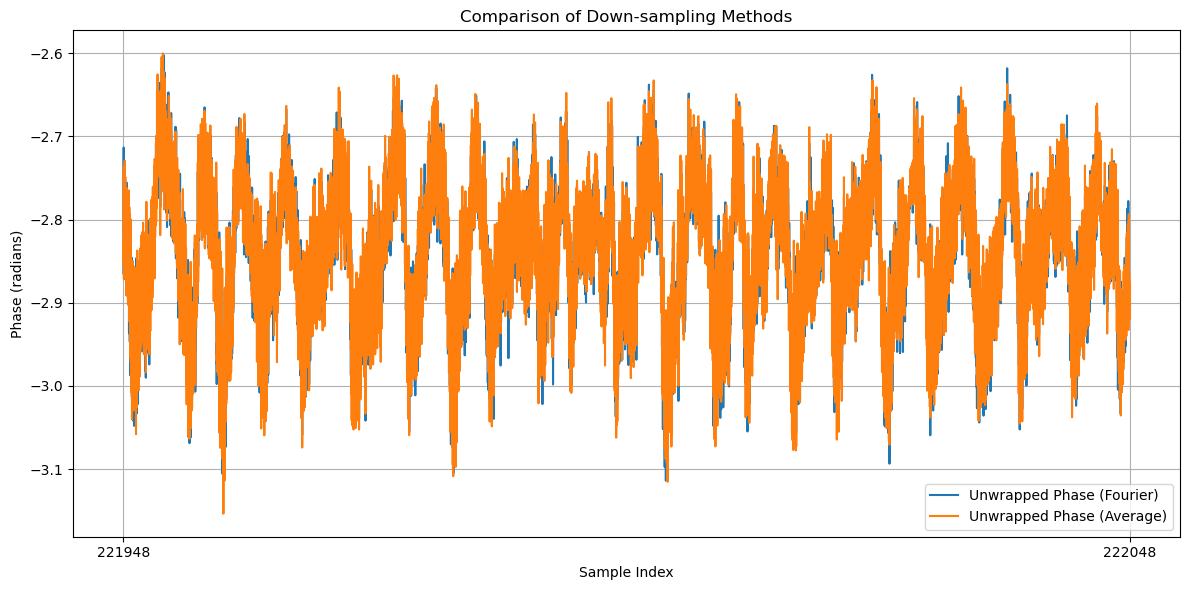

In [76]:
from scipy.signal import resample

data = data_subset

# Extract the data columns
timestamps = data['timestamp'].astype(str)
data_i = data['data_i'].astype(float)
data_q = data['data_q'].astype(float)

# Convert the timestamps to datetime objects
timestamps = pd.to_datetime(timestamps, format='%Y-%m-%d %H:%M:%S.%f')

# Calculate the original sampling rate
time_diffs = timestamps.diff().dropna()
avg_time_diff = time_diffs.mean().total_seconds()
original_sampling_rate = 1 / avg_time_diff

# Desired sampling rate for downsampling
desired_sampling_rate = 128
downsample_factor = int(original_sampling_rate / desired_sampling_rate)

# 1. Fourier method down-sampling
data_i_fourier = resample(data_i, len(data_i) // downsample_factor)
data_q_fourier = resample(data_q, len(data_q) // downsample_factor)
# timestamps_downsampled = resample(timestamps.astype(int).values, len(timestamps) // downsample_factor)
# timestamps_downsampled = pd.to_datetime(timestamps_downsampled)

# 2. Average method down-sampling
def average_downsample(signal, factor):
    n = len(signal) // factor
    return np.mean(signal.values[:n*factor].reshape(-1, factor), axis=1)


data_i_avg = average_downsample(data_i, downsample_factor)
data_q_avg = average_downsample(data_q, downsample_factor)

# Perform arctan demodulation
sig_fourier = np.arctan2(data_q_fourier, data_i_fourier)
sig_avg = np.arctan2(data_q_avg, data_i_avg)

# Perform phase unwrapping
sig_unwrapped_fourier = np.unwrap(sig_fourier)
sig_unwrapped_avg = np.unwrap(sig_avg)

# # Extract HMS from the downsampled timestamps
timestamps_hms = timestamps.dt.strftime('%H%M%S')

# Plot the processed data
plt.figure(figsize=(12, 6))
plt.plot(sig_unwrapped_fourier, label='Unwrapped Phase (Fourier)')
plt.plot(sig_unwrapped_avg, label='Unwrapped Phase (Average)')
plt.xlabel('Sample Index')
plt.ylabel('Phase (radians)')
plt.title('Comparison of Down-sampling Methods')
plt.legend()
plt.grid(True)

# Adjust x-axis labels to show only the start and end
plt.xticks([0, len(sig_unwrapped_fourier) - 1], [timestamps_hms.iloc[0], timestamps_hms.iloc[-1]])

plt.tight_layout()
plt.show()

In [ ]:

print(f"Average time difference between samples: {avg_time_diff:.6f} seconds")
print(f"Estimated sampling rate: {sampling_rate:.2f} samples per second")


## 3. PSG signal processing

### Load data

In [5]:
import nbimporter
# Import the PSGDataProcessor class
from align_radar_psg import PSGDataProcessor

# Define the path to the EDF file
edf_file_path = "/Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/PSG/2024-6-20jiangyifan.edf"

# Create an instance of the PSGDataProcessor class
psg_processor = PSGDataProcessor()

# Load the data from the EDF file
psg_processor.load_data(edf_file_path)

# Access loaded data attributes
print(f"Sampling Rate: {psg_processor.sampling_rate}")
print(f"Channel Names: {psg_processor.ch_names}")
print(f"Start Datetime: {psg_processor.start_datetime}")



Extracting EDF parameters from /Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/PSG/2024-6-20jiangyifan.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


align_radar_psg.ipynb:28: RuntimeWarning: Physical range is not defined in following channels:
Thor, Abdo, Sum
  "import pandas as pd\n",


Reading 0 ... 29025279  =      0.000 ... 28344.999 secs...
Sampling Rate: 1024.0
Channel Names: ['E1-M2', 'E2-M2', 'Chin 1-Chin 2', 'F4-M1', 'C4-M1', 'O2-M1', 'F3-M2', 'C3-M2', 'O1-M2', 'ECG', 'Pressure', 'Therm', 'Thor', 'Abdo', 'Sum', 'Mic', 'Position', 'SpO2', 'Ox Status', 'Leg/L', 'Leg/R', 'Pulse', 'Pleth']
Start Datetime: 2024-06-20 22:02:34


### Extract and plot a single PSG channel

Index of channel 'ECG': 9


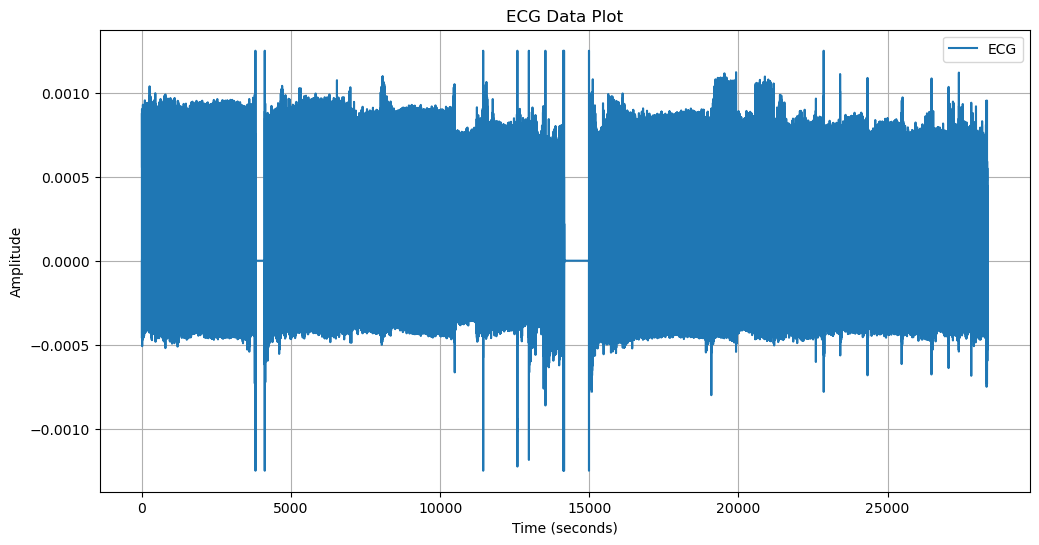

In [6]:
# Store channel names and their corresponding indices in a dictionary
channel_indices = {channel_name: idx for idx, channel_name in enumerate(psg_processor.ch_names)}

# Example usage: get the index of the 'ECG' channel
channel = 'ECG'
idx = channel_indices[channel]
print(f"Index of channel '{channel}': {idx}")
# Plot the data given channel index
psg_processor.plot_data(psg_processor.raw_data[idx],psg_processor.ch_names[idx], psg_processor.sampling_rate)


### Extract and plot given a time range

In [6]:
from datetime import datetime

# Extract data between two timestamps
start_datetime = datetime(2024, 6, 20, 22, 19, 48) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 22, 20, 48)  # Replace with your actual end datetime
data_types = ['ECG', 'Thor']  # Replace with your actual data types

extracted_data = psg_processor.extract_segment_by_timestamp(start_datetime, end_datetime, data_types)

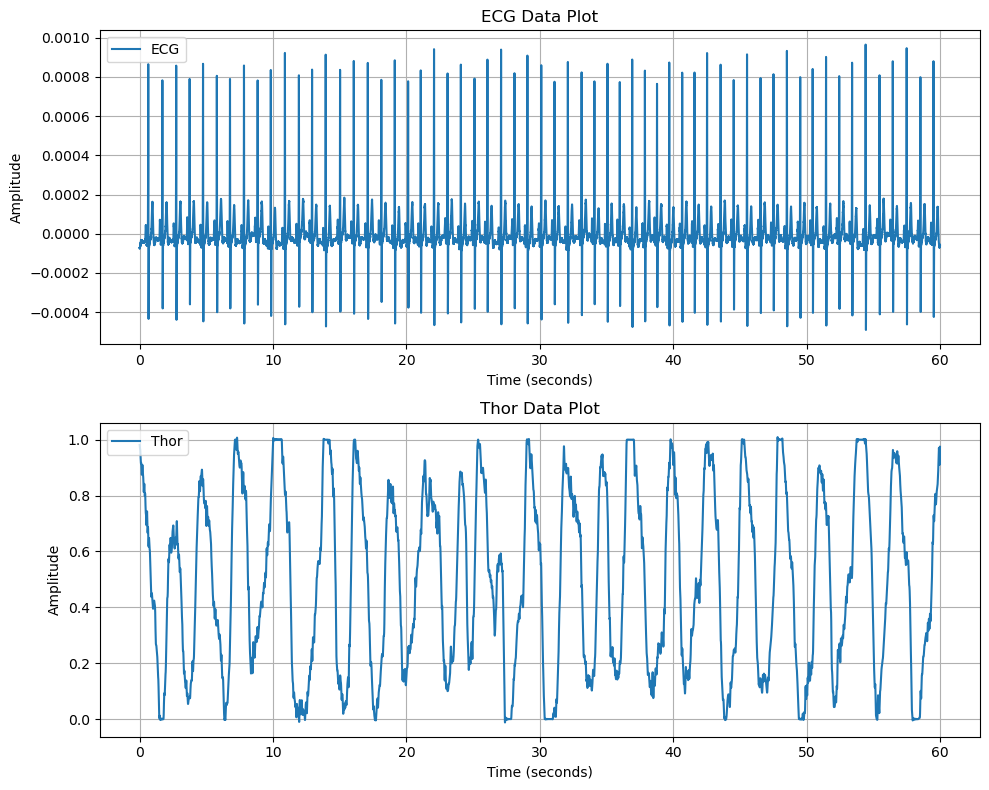

In [35]:
# Plot the comparison of extracted channels
psg_processor.compare_plot(extracted_data, data_types, psg_processor.sampling_rate)


## 4. Comparison: Radar, RGB and PSG Data


Bad key text.latex.unicode in file /Users/w.z/opt/anaconda3/envs/fall/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.8.0/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key text.latex.preview in file /Users/w.z/opt/anaconda3/envs/fall/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 125 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.8.0/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/w.z/opt/anaconda3/envs/fall/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 157 ('mathtext.

Extracting EDF parameters from /Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/PSG/2024-6-20jiangyifan.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


align_radar_psg.ipynb:28: RuntimeWarning: Physical range is not defined in following channels:
Thor, Abdo, Sum
  "import pandas as pd\n",


Reading 0 ... 29025279  =      0.000 ... 28344.999 secs...


/var/folders/l8/5lgpkmx16ksc0grqcv9pb52c0000gn/T/ipykernel_34949/346637115.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y%m%d%H%M%S%f')


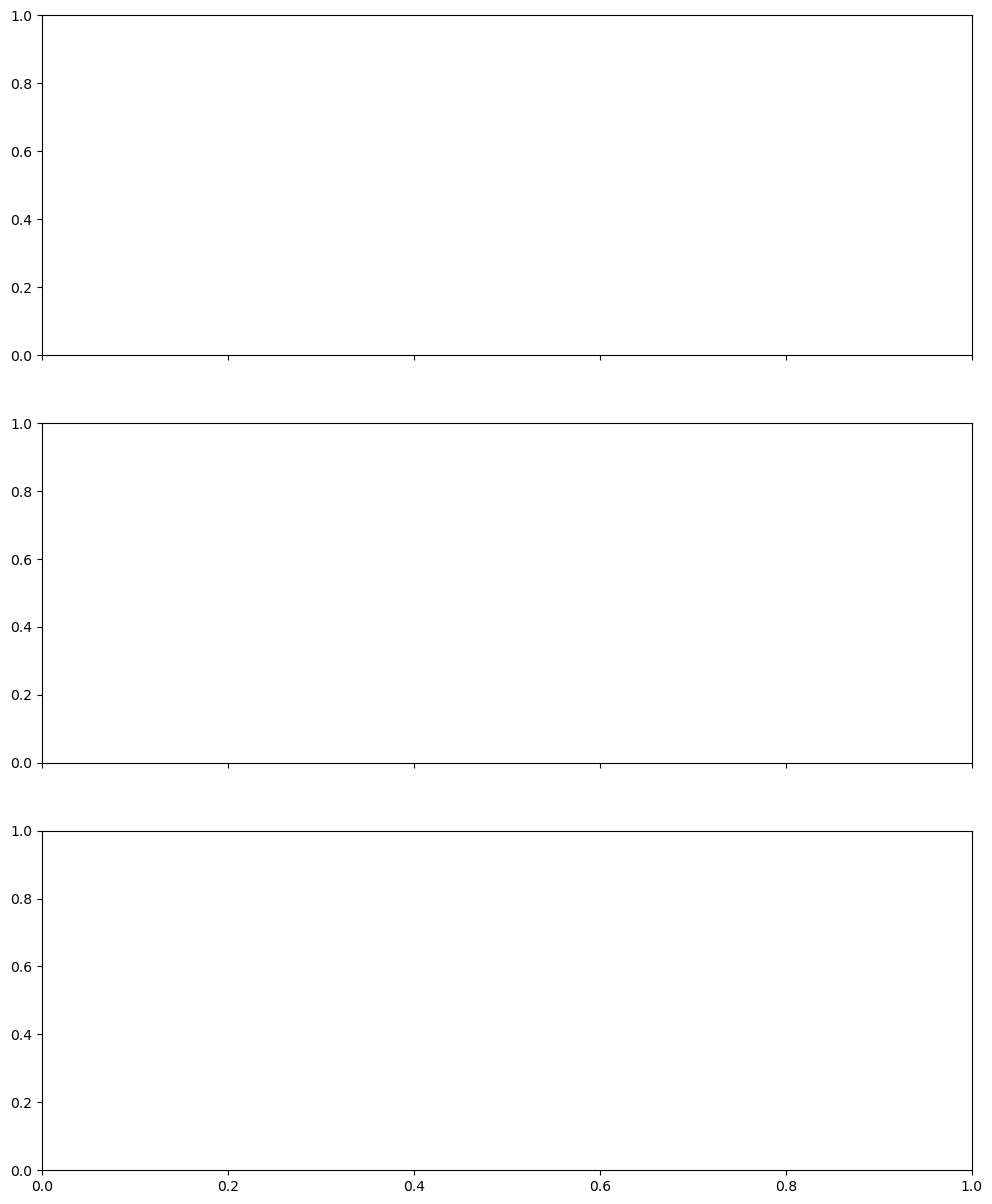

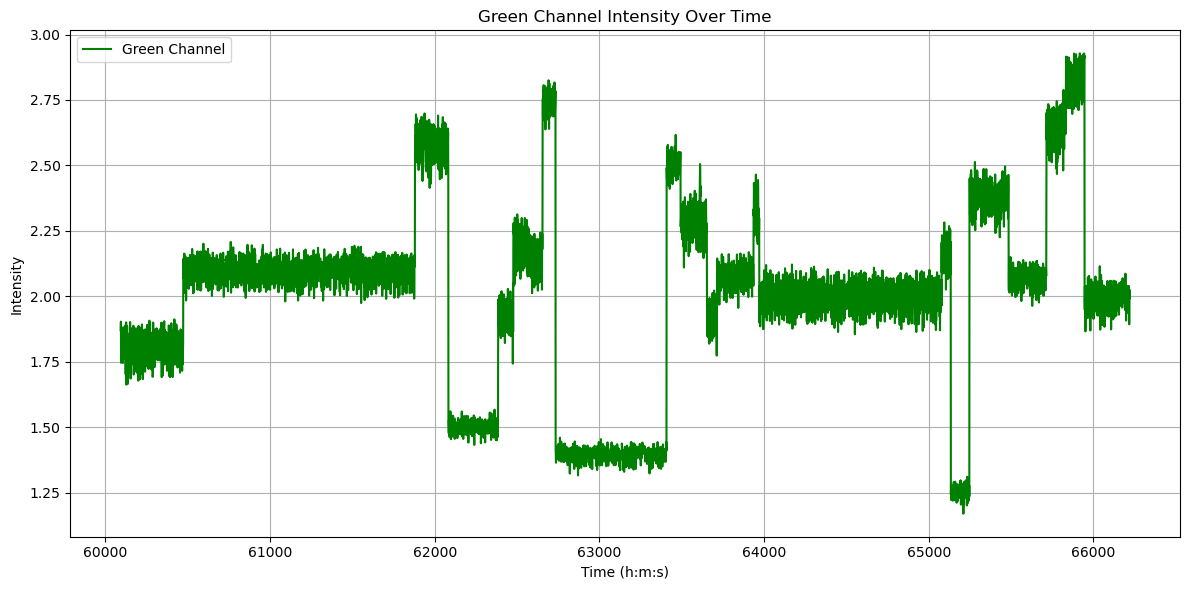

/var/folders/l8/5lgpkmx16ksc0grqcv9pb52c0000gn/T/ipykernel_34949/346637115.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y%m%d%H%M%S%f')


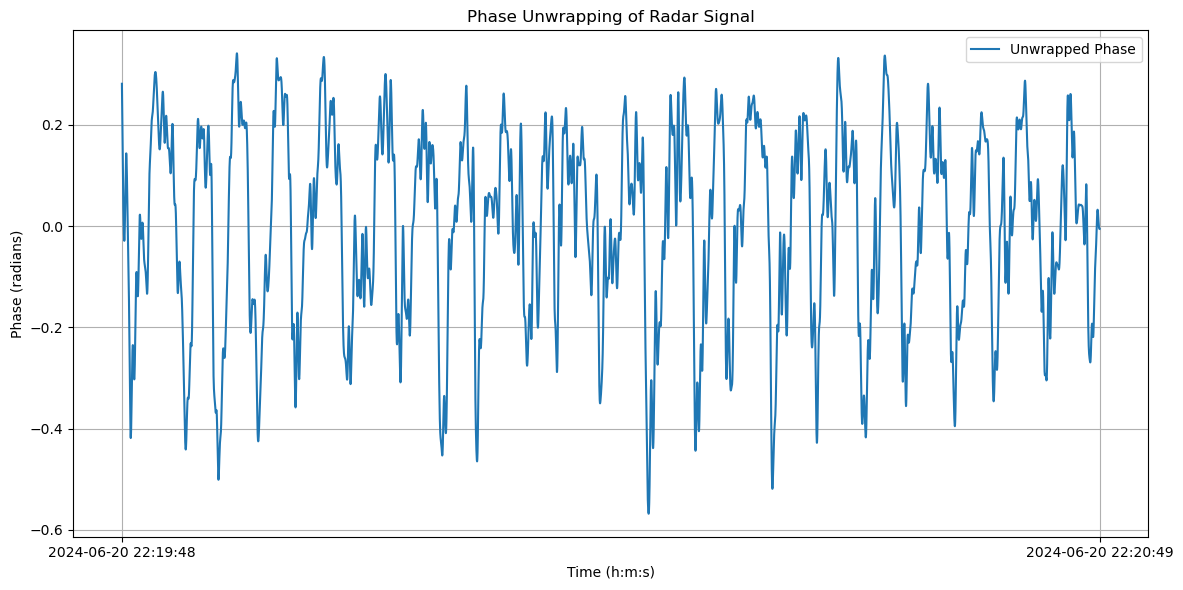

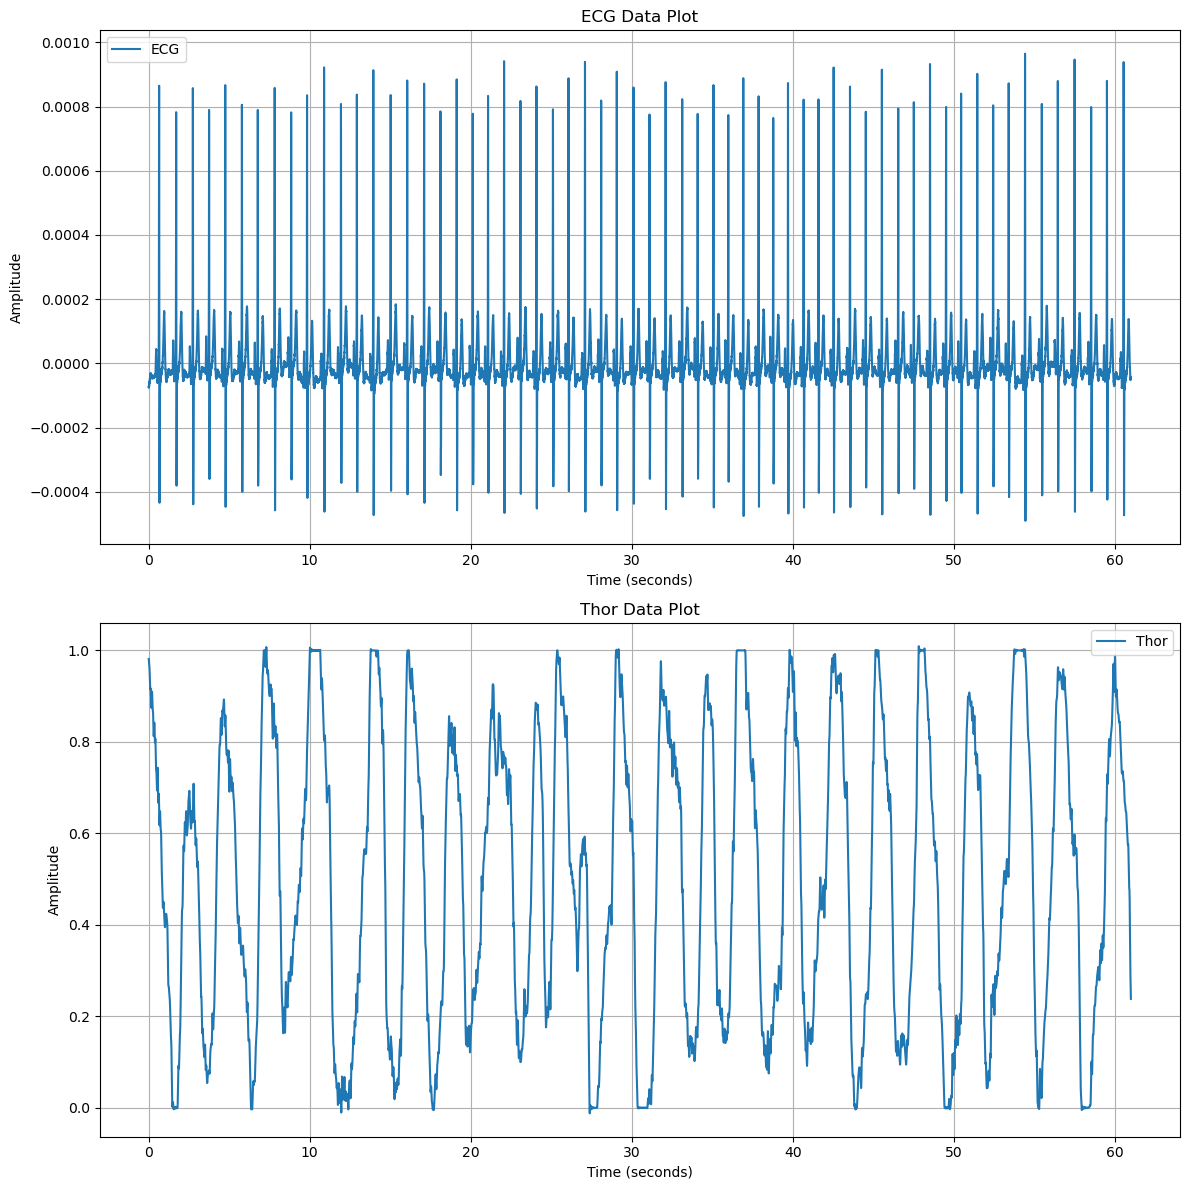

In [5]:
## 1. Load & extract data
# Load RGB data
rgb_file_path = '/Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/Camera/camera20240620220949415042.csv'
rgb_data = pd.read_csv(rgb_file_path)
rgb_data['timestamp'] = pd.to_datetime(rgb_data['timestamp'], format='%Y%m%d%H%M%S%f')

# Define the time range
start_datetime = datetime.strptime('20240620221948', '%Y%m%d%H%M%S')
end_datetime = datetime.strptime('20240620222049', '%Y%m%d%H%M%S')

# Extract the RGB data subset
rgb_subset = extract_data_subset(rgb_data, start_datetime, end_datetime)


# Load Radar data
radar_file_path = "/Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/Radar/radar20240620220948433561.csv"
radar_data = pd.read_csv(radar_file_path)
radar_data['timestamp'] = pd.to_datetime(radar_data['timestamp'], format='%Y%m%d%H%M%S%f')
sample_rate = 1000

# Extract the Radar data subset
radar_subset = extract_data_subset(radar_data, start_datetime, end_datetime)


# Load PSG data
psg_processor = PSGDataProcessor()
psg_processor.load_data("/Users/w.z/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/SleepData/苏州大学附属医院/PSG/2024-6-20jiangyifan.edf")
data_types = ['ECG', 'Thor']
# Extract PSG data for the same time range
psg_subset = psg_processor.extract_segment_by_timestamp(start_datetime, end_datetime, data_types)


## 2. Plot all data types
plot_rgb(rgb_subset, start_datetime, end_datetime)
plot_processed_data(radar_subset, sample_rate, start_datetime, end_datetime)
psg_processor.compare_plot(psg_subset, data_types, psg_processor.sampling_rate)


### Example usage: Plot ECG signal

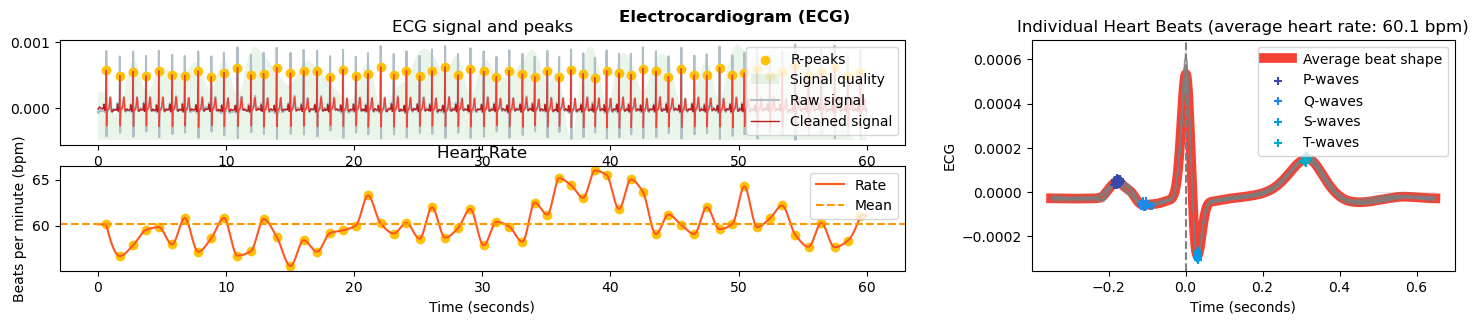

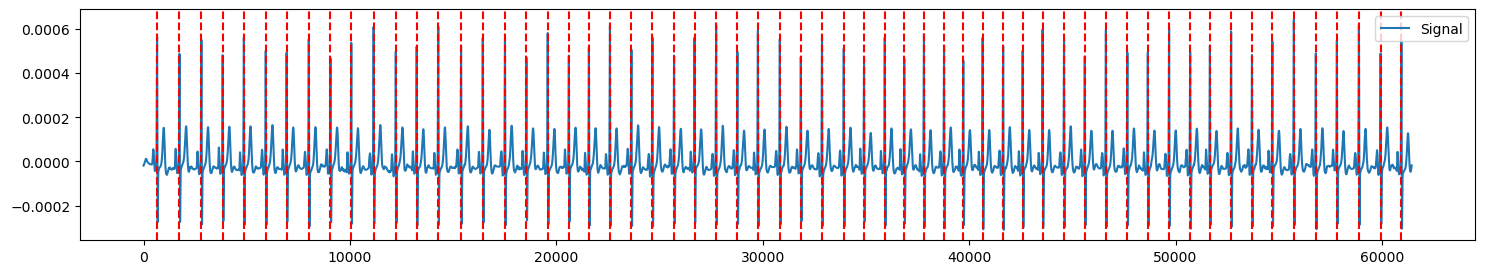

In [8]:
ecg_signals, ecg_info = psg_processor.ecg_diagram(extracted_data['ECG'])

### Example usage: Plot RSP signal

The raw signal, sampled at 1024.0 Hz, linear detrending followed by a fifth order 2Hz low-pass IIR Butterworth filter; following Khoadadad et al., 2018.

The peak detection was carried out using the method described in Khoadadad et al. (2018).

The respiratory volume per time computation was carried out using the method described in Harrison et al. (2021).

|   RSP_Rate_Mean |   RSP_Rate_SD |
|----------------:|--------------:|
|         22.9796 |       3.79603 |

References
- Harrison, S. J., Bianchi, S., Heinzle, J., Stephan, K. E., Iglesias, S., & Kasper, L. (2021).
            A Hilbert-based method for processing respiratory timeseries.
            Neuroimage, 230, 117787.
- Khodadad, D., Nordebo, S., Müller, B., Waldmann, A., Yerworth, R., Becher, T., ... & Bayford, R. (2018).
            Optimized breath detection algorithm in electrical impedance tomography.
            Physiological measurement, 39(9), 094001.
- Khodadad, D., Nordebo, S., Müller, B., Waldmann, A., Yerworth, R.

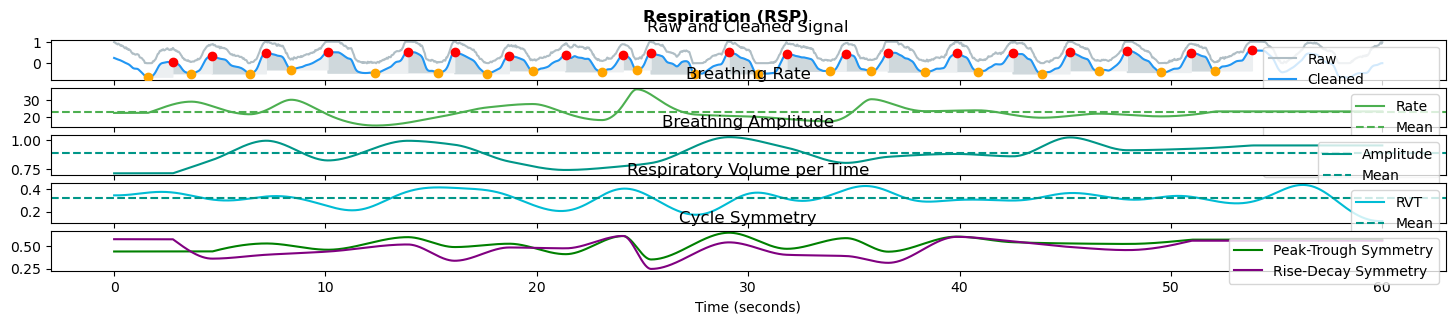

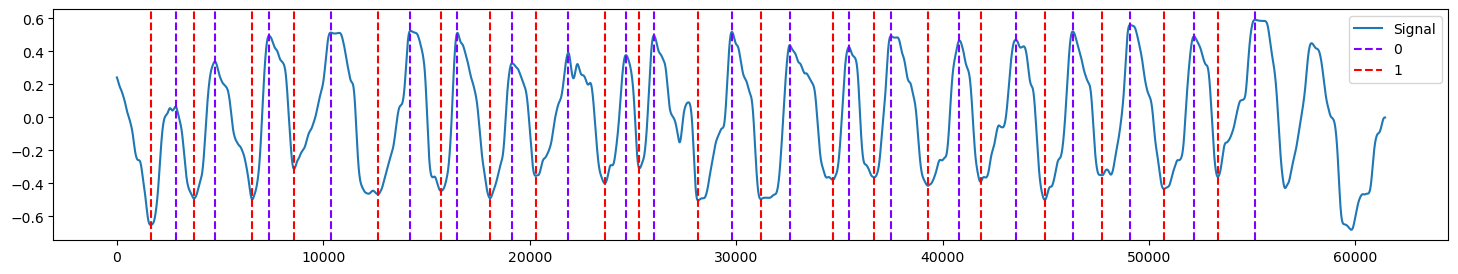

In [7]:
rsp_signals, rsp_info = psg_processor.rsp_diagram(extracted_data['Thor'])

### Example usage: Plot multiple PSG signals

In [9]:
psg_processor.ch_names

['E1-M2',
 'E2-M2',
 'Chin 1-Chin 2',
 'F4-M1',
 'C4-M1',
 'O2-M1',
 'F3-M2',
 'C3-M2',
 'O1-M2',
 'ECG',
 'Pressure',
 'Therm',
 'Thor',
 'Abdo',
 'Sum',
 'Mic',
 'Position',
 'SpO2',
 'Ox Status',
 'Leg/L',
 'Leg/R',
 'Pulse',
 'Pleth']

Start Timestamp: 2024-06-20 22:19:48, End Timestamp: 2024-06-20 22:20:48
Index(['ECG_Raw', 'ECG_Clean', 'ECG_Rate', 'ECG_Quality', 'ECG_R_Peaks',
       'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks',
       'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks',
       'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial',
       'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
       'ECG_Phase_Completion_Ventricular', 'RSP_Raw', 'RSP_Clean',
       'RSP_Amplitude', 'RSP_Rate', 'RSP_RVT', 'RSP_Phase',
       'RSP_Phase_Completion', 'RSP_Symmetry_PeakTrough',
       'RSP_Symmetry_RiseDecay', 'RSP_Peaks', 'RSP_Troughs', 'RSA_P2T',
       'RSA_Gates'],
      dtype='object')


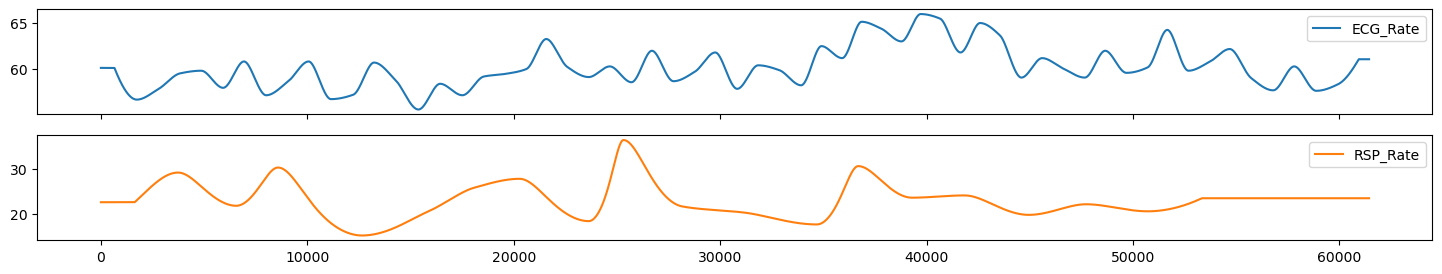

In [16]:
# Extract data between two timestamps
start_datetime = datetime(2024, 6, 20, 22, 19, 48) # Replace with your actual start datetime
end_datetime = datetime(2024, 6, 20, 22, 20, 48)  # Replace with your actual end datetime
data_types = ['ECG', 'Thor']  # Replace with your actual data types

# Print the start and end timestamps of the extracted data
print(f"\033[93mStart Timestamp: {start_datetime}, End Timestamp: {end_datetime}\033[0m")

extracted_data = psg_processor.extract_segment_by_timestamp(start_datetime, end_datetime, data_types)
psg_processor.signals_diagram(extracted_data)
